In [474]:
import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.python.ops import nn
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import initializers
from tensorflow.python.ops import variables as tf_variables

tf.config.run_functions_eagerly(True)

In [475]:
EPOCHS = 3
BATCH_SIZE = 32
SEED = 42

DEBUG = True

In [476]:
def set_seed(seed=SEED):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed()

In [477]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if DEBUG:
    x_train, y_train = x_train[:200], y_train[:200]
    x_test, y_test = x_test[:50], y_test[:50]

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [478]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(200, 28, 28, 1)
(200,)
(50, 28, 28, 1)
(50,)


In [479]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [480]:
################################
# バッチ正規化
################################

class BatchNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon

    def build(self, input_shape):

        ### 重みパラメータの形が重要 ###
        weight_shape = [1] * len(input_shape)
        weight_shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.moving_mean = self.add_weight(
            name='moving_mean',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            synchronization=tf_variables.VariableSynchronization.ON_READ,
            trainable=False,
            aggregation=tf_variables.VariableAggregation.MEAN,
            experimental_autocast=False)

        self.moving_variance = self.add_weight(
            name='moving_variance',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            synchronization=tf_variables.VariableSynchronization.ON_READ,
            trainable=False,
            aggregation=tf_variables.VariableAggregation.MEAN,
            experimental_autocast=False)

        self.built = True

    def call(self, x, training=None):

        ### どこを穴埋めにするか? ###
        if training:
            mean, variance = tf.nn.moments(x, [i for i in range(len(x.shape) - 1)], keepdims=True)
            x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * mean
            self.moving_variance = self.momentum * self.moving_variance + (1 - self.momentum) * variance
        else:
            x_std = (x - self.moving_mean) / math_ops.sqrt(self.moving_variance + self.epsilon)

        ret = self.gamma * x_std + self.beta
        return ret

In [481]:
################################
# レイヤー正規化
################################

class LayerNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon

    def build(self, input_shape):

        ### 重みパラメータの形が重要 ###
        weight_shape = 1

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.built = True

    def call(self, x, training=None):

        ### どこを穴埋めにするか? ###
        mean, variance = tf.nn.moments(x, [i for i in range(1, len(x.shape))], keepdims=True)
        x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
        ret = self.gamma * x_std + self.beta

        return ret

In [482]:
################################
# インスタンス正規化
################################

class InstanceNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon

    def build(self, input_shape):

        ### 重みパラメータの形が重要 ###
        weight_shape = [1] * len(input_shape)
        weight_shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.built = True

    def call(self, x, training=None):

        ### どこを穴埋めにするか? ###
        mean, variance = tf.nn.moments(x, [i for i in range(1, len(x.shape) - 1)], keepdims=True)
        x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
        ret = self.gamma * x_std + self.beta

        return ret

In [483]:
################################
# モデル定義
################################

class BatchModel(Model):
    def __init__(self):
        super(BatchModel, self).__init__()
        self.conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.norm1 = BatchNormalization()
        self.pooling1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.norm2 = BatchNormalization()
        self.pooling2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.norm1(x, training)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.norm2(x, training)
        x = self.pooling2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


class LayerModel(Model):
    def __init__(self):
        super(LayerModel, self).__init__()
        self.conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.norm1 = LayerNormalization()
        self.pooling1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.norm2 = LayerNormalization()
        self.pooling2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.norm1(x, training)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.norm2(x, training)
        x = self.pooling2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


class InstanceModel(Model):
    def __init__(self):
        super(InstanceModel, self).__init__()
        self.conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.norm1 = InstanceNormalization()
        self.pooling1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.norm2 = InstanceNormalization()
        self.pooling2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.norm1(x, training)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.norm2(x, training)
        x = self.pooling2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


batch_model = BatchModel()
layer_model = LayerModel()
instance_model = InstanceModel()

In [484]:
################################
# メインループ
################################

def main(model):

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    @tf.function
    def train_step(model, images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def test_step(model, images, labels):
        predictions = model(images, training=False)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    result_train_loss = np.zeros(EPOCHS)
    result_train_accuracy = np.zeros(EPOCHS)
    result_test_loss = np.zeros(EPOCHS)
    result_test_accuracy = np.zeros(EPOCHS)

    # メインループ
    for epoch in range(EPOCHS):

        print(f'---Epoch: {epoch+1}---')

        # 訓練
        for images, labels in train_ds:
            train_step(model, images, labels)

        result_train_loss[epoch] = train_loss.result()
        result_train_accuracy[epoch] = train_accuracy.result()
        log_txt = f'{"[train]":<10} Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()*100}'
        print(log_txt)

        # テスト
        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)

        result_test_loss[epoch] = test_loss.result()
        result_test_accuracy[epoch] = test_accuracy.result()
        log_txt = f'{"[test]":<10} Loss: {test_loss.result()}, Accuracy: {test_accuracy.result()*100}'
        print(log_txt)

        # 損失などの初期化
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    # 描画
    x = np.arange(1, EPOCHS + 1)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.plot(x, result_train_loss, label="train_loss")
    ax.plot(x, result_test_loss, label="test_loss")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.plot(x, result_train_accuracy, label="train_accuracy")
    ax.plot(x, result_test_accuracy, label="test_accuracy")
    plt.legend()
    plt.show()

---Epoch: 1---
[train]    Loss: 2.0449864864349365, Accuracy: 43.5
[test]     Loss: 2.1780147552490234, Accuracy: 52.0
---Epoch: 2---
[train]    Loss: 0.3667951226234436, Accuracy: 89.5
[test]     Loss: 2.0792946815490723, Accuracy: 28.0
---Epoch: 3---
[train]    Loss: 0.14633353054523468, Accuracy: 96.5
[test]     Loss: 2.1751739978790283, Accuracy: 18.0


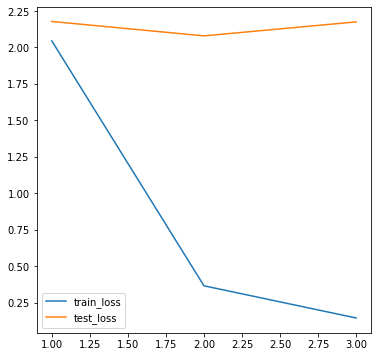

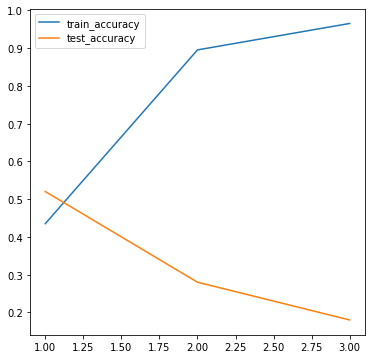

In [485]:
main(batch_model)

---Epoch: 1---
[train]    Loss: 2.2228643894195557, Accuracy: 37.5
[test]     Loss: 1.2740024328231812, Accuracy: 54.000003814697266
---Epoch: 2---
[train]    Loss: 0.9221073389053345, Accuracy: 70.5
[test]     Loss: 0.8222271800041199, Accuracy: 76.0
---Epoch: 3---
[train]    Loss: 0.41155806183815, Accuracy: 87.5
[test]     Loss: 0.6005348563194275, Accuracy: 84.0


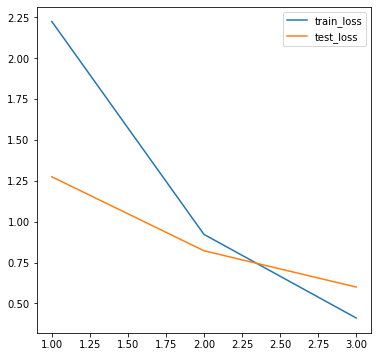

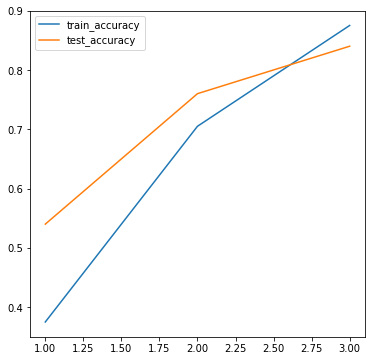

In [486]:
main(layer_model)

---Epoch: 1---
[train]    Loss: 1.98441481590271, Accuracy: 48.5
[test]     Loss: 0.9869702458381653, Accuracy: 68.0
---Epoch: 2---
[train]    Loss: 0.46383339166641235, Accuracy: 85.5
[test]     Loss: 0.5648265480995178, Accuracy: 82.0
---Epoch: 3---
[train]    Loss: 0.15140797197818756, Accuracy: 95.0
[test]     Loss: 0.5202119946479797, Accuracy: 84.0


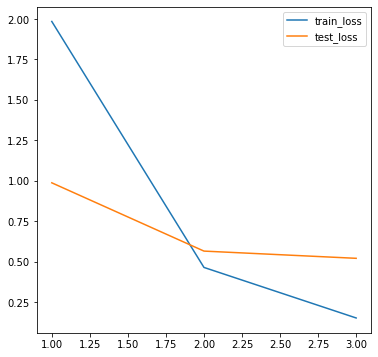

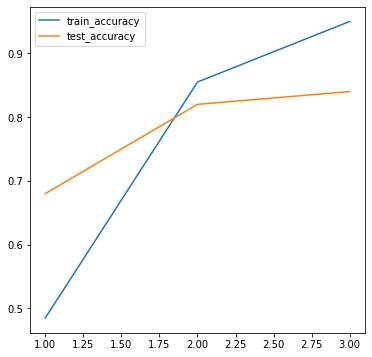

In [487]:
main(instance_model)